# Test run this notebook on GPU:
http://sabre:8951/notebooks/LineageTracing/PrimeEditor_new/Image_Processing/20230830-4T1v21x_segmentation.ipynb


In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
print(os.getpid())

95839


In [2]:
torch.cuda.is_available()

True

In [3]:
# ChromAn ris_availabled imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive

## Data folder

In [89]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.1x'
#data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_2day/'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.1x
-- 1 folders, 156 fovs detected.


In [90]:
# color usage
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_labelX.csv')
#color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_clearing.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.1x/Analysis/color_usage_labelX.csv


# Manual

In [91]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive

import h5py

In [92]:
_fov_id = 24
_fov_filename = os.path.join(folders[0], fovs[_fov_id])

In [93]:
_fov_savefile = _fov_filename.replace('.dax', '.hdf5')
with h5py.File(_fov_savefile, 'r') as _f:
    print(_f['H0M1']['405'].keys())
    _dapi_im = _f['H0M1']['405']['im'][:]

<KeysViewHDF5 ['im']>


In [94]:
# load image
daxp = dax_process.DaxProcesser(
    _fov_filename,
    CorrectionFolder=r'/lab/weissman_imaging/puzheng/PE_LT/20230902-zombie_4T1preEditEmx1/Corrections' )

daxp._load_image()
daxp._corr_illumination(correction_channels=['405'])

Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.1x/H0M1/Conv_zscan_024.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.1x/H0M1/Conv_zscan_024_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  40 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 8.719s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
- Start illumination correction for channels:['405'].
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 405 in 2.877s.
- Finished illumination correction in 2.889s.


# run quick segmentation

In [95]:
# Cellpose 
from cellpose import models
import time

In [96]:
import cv2
#_dapi_im = daxp.im_405
test_dapi_im = np.array([cv2.resize(_ly, (1152,1152)) for _ly in _dapi_im])
#test_dapi_im = daxp.im_405

In [97]:
# Create cellpose model
print(f"- run Cellpose segmentation", end=' ')
_cellpose_start = time.time()
torch.cuda.empty_cache() # empty cache to create new model
seg_model = models.CellposeModel(gpu=True, model_type='nuclei')

_segmentation_kwargs = {
    'diameter': 180,
    'anisotropy': 500/107,
    'min_size': 16000,
    'do_3D': True,
}
_used_segmentation_kwargs = {_k:_v for _k,_v in _segmentation_kwargs.items()}
rescale_factor = 0.5

# modify size based on rescaling:
_used_segmentation_kwargs['diameter'] = _used_segmentation_kwargs['diameter'] * rescale_factor
_used_segmentation_kwargs['anisotropy'] = _used_segmentation_kwargs['anisotropy'] * rescale_factor
_used_segmentation_kwargs['min_size'] = _used_segmentation_kwargs['min_size'] * rescale_factor**2

# Run cellpose prediction
labels3d, _, _ = seg_model.eval(np.stack([test_dapi_im,test_dapi_im], axis=3), 
                                channels=[0,0], 
                                **_used_segmentation_kwargs,
                                )
print(f"in {time.time()-_cellpose_start:.3f}s.")

- run Cellpose segmentation in 146.405s.


In [98]:
# resize segmentation label back
corr_labels3d = np.array([cv2.resize(_ly, _dapi_im.shape[-2:], 
                                interpolation=cv2.INTER_NEAREST_EXACT) 
                     for _ly in labels3d])

<IPython.core.display.Javascript object>


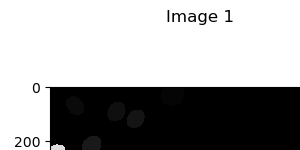

In [99]:
%matplotlib notebook
interactive.imshow_mark_3d([ labels3d])

<IPython.core.display.Javascript object>


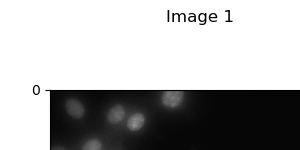

In [100]:
%matplotlib notebook
interactive.imshow_mark_3d([_dapi_im, labels3d])

## save parameters

In [19]:
# summarize parameter files:
import pickle
merged_parameters = {
    'cellpose_params': _segmentation_kwargs,
}
# save
parameter_savefile = os.path.join(analysis_folder, 'H0_CellposeParam.pkl')
print(parameter_savefile)
pickle.dump(merged_parameters, open(parameter_savefile, 'wb'), )

/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x/Analysis/H0_CellposeParam.pkl


In [20]:
merged_parameters

{'cellpose_params': {'diameter': 180,
  'anisotropy': 4.672897196261682,
  'min_size': 16000,
  'do_3D': True}}

<IPython.core.display.Javascript object>


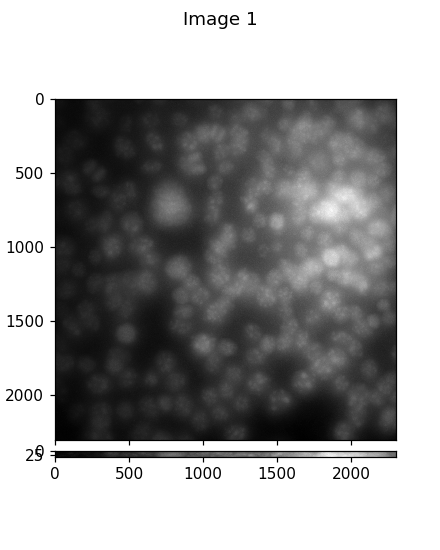

In [46]:
%matplotlib notebook
interactive.imshow_mark_3d([daxp.im_405, labels3d])

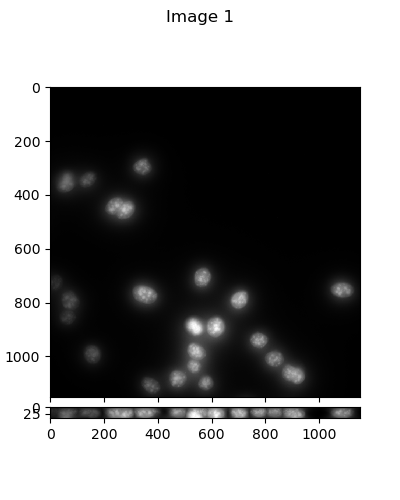

In [99]:
interactive.imshow_mark_3d([test_dapi_im, labels3d])

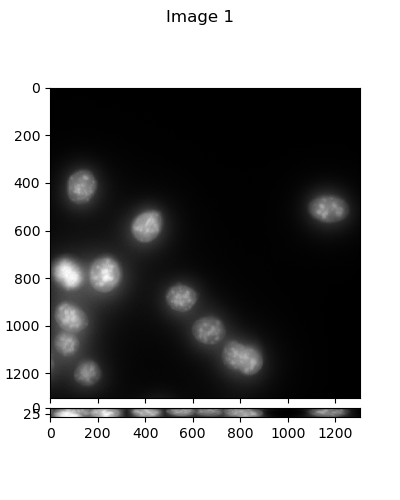

In [54]:
interactive.imshow_mark_3d([daxp.im_405[:,1000:,1000:], labels3d])

<IPython.core.display.Javascript object>


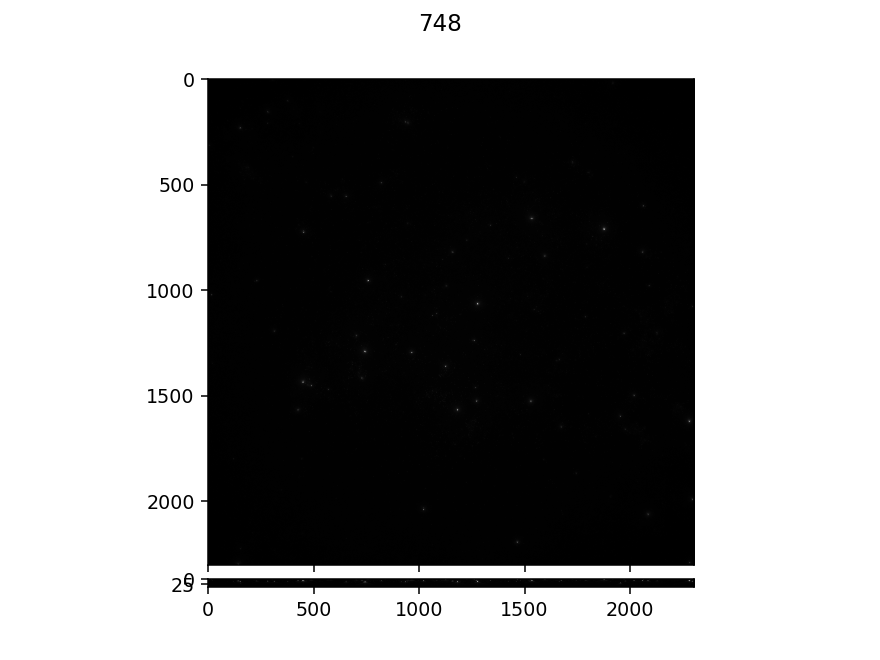

In [21]:
%matplotlib notebook
f = plt.figure(dpi=125)
interactive.imshow_mark_3d(
    [getattr(daxp, f"im_{_ch}") for _ch in daxp.channels], 
    fig=f,
    image_names=daxp.channels, 
    min_max_default=[0,20000],
    )
f.show()

In [ ]:
# Job 1: preprocess images, save
# Job 2: spot fitting
# Job 3: segmentation, submit to GPU node
